In [1024]:
import numpy as np
from astropy import units as u
from astropy import time
from astropy import coordinates as c
import os
from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from poliastro.twobody.propagation import propagate
from poliastro.examples import iss
import matplotlib.pyplot as plt
from poliastro import iod
from poliastro.bodies import Earth, Mars, Sun
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter
from poliastro.earth.atmosphere import COESA76
from poliastro.twobody.propagation import cowell
from poliastro.plotting import OrbitPlotter3D
from poliastro.util import norm
import plotly.io as pio
pio.renderers.default = "notebook_connected"
from poliastro.twobody.events import LithobrakeEvent
from astropy.coordinates import SphericalRepresentation
import math as Math
from poliastro.twobody import Orbit
from poliastro.mars_atm import MartianAtmosphere

from scipy.ndimage import rotate
from scipy.spatial.transform import Rotation as R

In [1025]:
#Mars has an atmosphere and some gravity
atmosphere = MartianAtmosphere()
mu = Mars.k.to(u.km**3/u.s**2).value
density=  0


#starship entry coefficients
flat_area = 665 * (u.m**2)
dry_mass = 163*1e3 * u.kg
a_m = (flat_area/dry_mass).value
r_curvature = 4.5

AoA = 60


#lifting area is reduced by some factor from drag area
a_m_l = ((flat_area/dry_mass)*0.75).value

#typical hypersonic regime, lift coefficient is ~ 3.7, drag ~ 9.5, l/d ~ 0.4    
# or, c_l = ~0.45, & c_d = 0.9 at AoA 60
# c_d =8.5
# c_l=4
d_factor = 1
c_d = 8
c_l = 6


Speed at periapsis is 8.801245478795416 km / s
Periapsis is 67.2184999999995 km


c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"



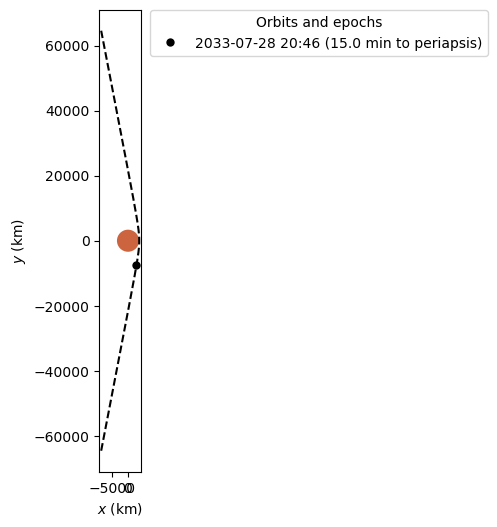

In [1026]:
body_2 = Mars
#generate the hyperbolic entry orbit from the C3 calculated in the interplanerary traj
c3_a = 52.73*(u.km**2)/(u.s**2)#arrival C3
r_p = 67.2185*u.km#arrival periapsis
inverse_speed_threshold = 0.6#km/s above escape velocity that the Starship should invert to positive lift in order to avoid crashing into Mars.


date_arrival = time.Time("2033-07-28 21:01", scale="utc").tdb

a_exit = -(body_2.k / c3_a).to(u.km)
ecc_exit = 1 - (r_p+body_2.R) / a_exit

initial_orbit = Orbit.from_classical(
    body_2,
    a_exit,
    ecc_exit,
    0 * u.deg,
    0 * u.deg,
    0 * u.deg,
    0 * u.deg,  # We don't mind
    time.Time(date_arrival, scale="utc"),
)
time_to_entry = 15*u.min

periapsis_orb = initial_orbit.propagate(-time_to_entry)
print(f"Speed at periapsis is {np.linalg.norm(initial_orbit.v)}")
print(f"Periapsis is {initial_orbit.r_p-Mars.R}")

earth_ejection_plotter = StaticOrbitPlotter()
earth_ejection_plotter.plot(periapsis_orb, label=f"{time_to_entry} to periapsis", color="k")



In [1027]:

#hyperbolic orb parems
# p = [3495,-12456,0]*u.km
# v = [4.237,10.812,0]*u.km / u.s


In [1028]:
def stagnation_temperature(V_inf, T_inf, Cp=1000, dissociation_correction=True):
    """Calculate stagnation temperature considering real gas effects."""
    T0 = T_inf + (V_inf ** 2) / (2 * Cp)
    
    if dissociation_correction:
        # Apply empirical correction for air dissociation at high temperatures
        if T0 > 5000:
            T0 = 14000 - 5000 * np.exp(-T0 / 7000)  # Rough empirical correction
    
    return T0

def boundary_layer_edge_temperature(M, T0, gamma=1.4, real_gas=True):
    """Calculate temperature at the boundary layer edge considering real gas effects."""
    
    if real_gas:
        # For high Mach numbers, gamma decreases due to dissociation and ionization
        gamma_eff = max(1.2, 1.4 - 0.1 * np.log10(M))  # Approximate trend
    else:
        gamma_eff = gamma
    
    Te = T0 / (1 + ((gamma_eff - 1) / 2) * M ** 2)
    
    return Te

In [1029]:



#Cowell propagation on the entry trajectory

prop_total = 500
reentry_vel = []
reentry_time = []
reentry_alts = []
reentry_accs_dumb = []
stagnation_heat_fluxs = []
entry_interface = 0

lift_direction = 90#90 for inverted, -90 for normal, others to take roll into acount
reentry_angle = 0
flip_time = 0


def reentry_accel(accel):
    def constant_accel(t0, state, k):
        v = state[3:]
        square_v = (v[0]**2 + v[1]**2 + v[2]**2) #km^2/s^2
        norm_v = square_v**.5
        p = state[:3]
        #print(p)
        alt = 1e-3*(np.linalg.norm(p)*1e3-Mars.R.value)*u.km#alt in km

        global orb_fin
        global entry_interface
        global reentry_vel
        global reentry_time
        global reentry_alts
        global stagnation_heat_fluxs
        global reentry_accs_dumb
        global reentry_angle
        global lift_direction
        global flip_time

        if alt<100*u.km and alt>0*u.km:
            if(reentry_angle == 0):
                r_hat = p/np.linalg.norm(p)
                AoA_lift_rot = R.from_euler('z',90,degrees=True)
                #lift vector
                theta_hat = AoA_lift_rot.apply(r_hat)    
                print("Calculating reentry angle.")
                reentry_angle = np.arccos(np.dot(v/norm_v,theta_hat))

            if(norm_v<Mars.escape_velocity().value+inverse_speed_threshold and lift_direction ==90):
                print(f"Inverting at {t0}")
                flip_time = t0
                lift_direction = -90


            density = 0*u.kg/(u.m**3)
            props = atmosphere.properties(alt.value)
            density = props["density_kg_m3"]*u.kg/(u.m**3)#kg/m^3
            pressure = props["pressure_Pa"]
            static_temp = props["temperature_K"]*u.k
            properties = 0
            if(alt>0*u.km):
                ah = alt.value
                

            #f_d = 0.5*rho*v^2*C_d*a
            # print(f"density at {alt} is {density}")
            # print(square_v)
            #square_v is km^2/s^2 so convert to m^2/s^2, and then convert final acceleration from m/s^2 to km/s^2
            #print((v))
            drag_acc = -0.5*density.value*square_v*1e6*c_d*a_m * v * 1e-3 / (norm_v )# km/s^2
            AoA_lift_rot = R.from_euler('z',lift_direction,degrees=True)
            #lift vector
            lift_vec = AoA_lift_rot.apply(v)
            # print(v)
            # print(f"rotate {lift_vec}")

            # lift_acc = 0*lift_vec
            # if alt<75*u.km:
            lift_acc = 0.5*a_m_l*c_l*square_v*density.value*1e6*lift_vec*1e-3/(norm_v)
            #lift_acc = lift_vec*10e-2/(norm_v)
            # print(f"lift {np.linalg.norm(lift_acc)}")
            # print(f"drag {np.linalg.norm(drag_acc)}")

            #Heat flux = 0.763*(Pr)^(-0.6)*(pmu)^(0.1)(du/dx)(h0e-hw)[1+(Le^(0.52)-1)(hd/h0e)]
            mach_vel = 225#m/s, emprical 
            mach_num = (square_v**0.5)*1e3/mach_vel

            #stagnation enthalpy ~ V_flow^2/2
            h0 = square_v*1e6*0.5
            #boundary layer edge temperature
            T0=stagnation_temperature((square_v**0.5)*1e3,static_temp.value)
            Te= boundary_layer_edge_temperature(mach_num,T0) 

            #viscosity at boundary layer with empirical fit
            mue = 1.45*1e-4*(Te/10000)**0.76
            #heat flux
            #p*he\sqrt{mu/(p*R)}
            qs = (density.value*h0*((mue)/(density*4.5))**0.5).value
            #Sutton-Graves
            heat_fluxs_dumb_val = (2.974e-4)*((density.value/r_curvature)**0.5)*((square_v*1e6)**1.5)*1e-3#at end convert to kW/m^2
            
            #print(t0)
            orb_fin = Orbit.from_vectors(Mars, p*u.km, v*u.km/u.s,epoch = date_arrival)
            if alt <120*u.km and entry_interface == 0:
                entry_interface = t0
            if alt <120*u.km:
                reentry_vel.append(norm_v)
                reentry_time.append(t0)
                reentry_alts.append(alt.value)
                stagnation_heat_fluxs.append(heat_fluxs_dumb_val)
                reentry_accs_dumb.append((d_factor*np.linalg.norm(drag_acc+lift_acc)*1e3))


            #print(acc)
            return 1.0*d_factor*(drag_acc+lift_acc)
        else:
            return 0*v

    return constant_accel


lithobrake_event = LithobrakeEvent(Mars.R.to(u.km).value)
events = [lithobrake_event]  

prop_time = 3000*(u.s)
times = np.linspace(0, prop_time, prop_total)
times
positions = propagate(
    periapsis_orb,
    time.TimeDelta(times),
    method=cowell,
    rtol=1e-14,
    ad=reentry_accel(10e-5),
    events = events
)
impact_time = 0
print(f"Reentry angle is {(180*reentry_angle)/Math.pi:.3f} degrees")

if entry_interface >0:
    print(f"Entry interface at {entry_interface} seconds")
if lithobrake_event.last_t.to(u.s)< prop_time:
    impact_time = lithobrake_event.last_t.to(u.s)
    print(f"Lithobrake event seen at {lithobrake_event.last_t.to(u.s).value} seconds")






# tofs = time.TimeDelta(np.linspace(0 * u.h, positions.norm().value.size*u.h, num=prop_total))
tofs = np.linspace(0 * u.s, prop_time.to(u.s), num=prop_total)
#pos_spherical = c.cartesian_to_spherical(positions[:][0],positions[:][1],positions[:][2])
pos_spherical = positions.represent_as(SphericalRepresentation)

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\scipy\integrate\_ivp\common.py:46: UserWarning:

`rtol` is too low, setting to 2.220446049250313e-14



Calculating reentry angle.


Inverting at 1045.3046255478037
Reentry angle is 7.087 degrees
Entry interface at 841.7524690530727 seconds


Entry interface at 841.7524690530727 seconds
Exit of entry regime at 1154.1504295547968 seconds 
Final apogee of 38206.30849024751 km
Final perigee of 25.221980516037547 km
Energy lost of 27.432183793442128 km2 / s2
Compares to normal ~30km^2/s^2 of LEO reentry


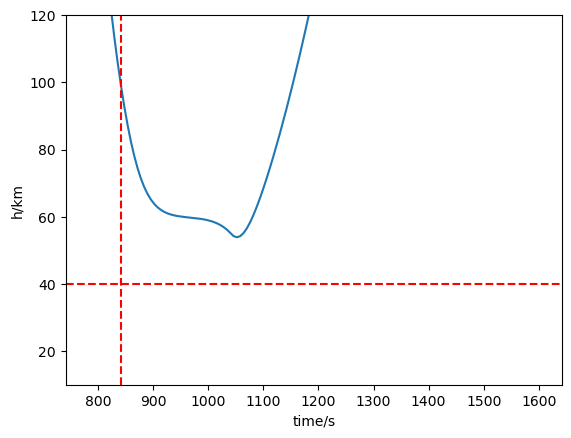

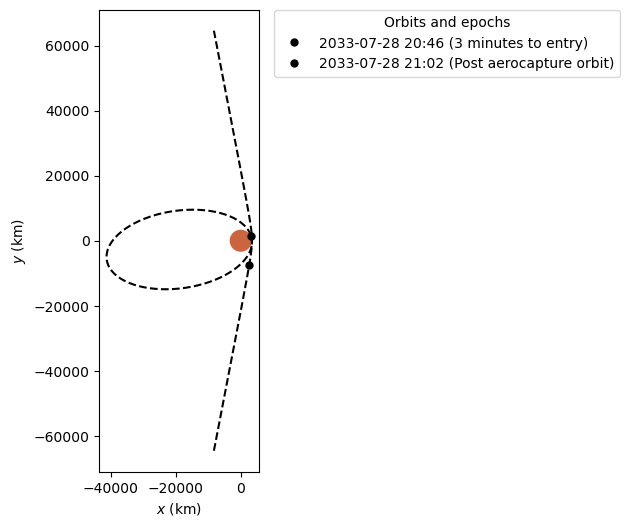

In [1030]:
if entry_interface >0:
    print(f"Entry interface at {entry_interface} seconds")
if lithobrake_event.last_t.to(u.s)< prop_time:
    impact_time = lithobrake_event.last_t.to(u.s)
    print(f"Lithobrake event seen at {lithobrake_event.last_t.to(u.s).value} seconds")
else:
    print(f"Exit of entry regime at {reentry_time[len(reentry_time)-1]} seconds ")

print(f"Final apogee of {orb_fin.r_a-Mars.R}")
print(f"Final perigee of {orb_fin.r_p-Mars.R}")
energy_lost = 0.5*(np.linalg.norm(initial_orbit.v)**2-np.linalg.norm(orb_fin.v)**2)
print(f"Energy lost of {energy_lost}")
print(f"Compares to normal ~30km^2/s^2 of LEO reentry")


plt.ylabel("h/km")
# plt.xlabel("distance downrange, km")
plt.xlabel("time/s")
#plt.axhline(impact_time)

#plt.xlim(12500,14000)
#plt.ylim(top = 100)
plt.plot(tofs, pos_spherical.distance - Mars.R)
plt.xlim(left=entry_interface-100,right=entry_interface+800)
plt.axvline(x=entry_interface,color = 'r',label='entry_interface',linestyle = '--')
plt.axhline(y=40,color = 'r',label='entry_interface',linestyle = '--')
plt.ylim(bottom = 10,top=120)
#plt.axvline(x=entry_interface,color = 'r',label='entry_interface')
plt.show()

final_orb_plotter = StaticOrbitPlotter()
final_orb_plotter.plot(periapsis_orb, label="3 minutes to entry", color="k")
final_orb_plotter.plot(orb_fin, label="Post aerocapture orbit", color="k")


In [1031]:
#calculate the accelerations
reentry_accs = np.diff(np.array(reentry_vel))/np.diff(np.array(reentry_time)+1)


C:\Users\jacki\AppData\Local\Temp\ipykernel_30592\2518044004.py:2: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\jacki\AppData\Local\Temp\ipykernel_30592\2518044004.py:2: RuntimeWarning:

invalid value encountered in true_divide



In [1032]:
#force times to integers,a nd then remove doubles
int_times = np.array(reentry_time).astype(int)

#print(int_times)

def remove_duplicates(arr1, arr2):
    """
    Removes duplicate entries from arr1 and their corresponding indices in arr2.

    Parameters:
        arr1 (numpy.ndarray): Array to remove duplicates from.
        arr2 (numpy.ndarray): Array with corresponding indices to remove.

    Returns:
        tuple: Filtered arr1 and arr2 with duplicates removed.
    """
    if arr1.shape != arr2.shape:
        raise ValueError("Both arrays must have the same shape")

    # Find unique values and their indices in arr1
    unique_values, unique_indices = np.unique(arr1, return_index=True)

    # Use the indices to filter arr2 as well
    filtered_arr1 = arr1[unique_indices]
    filtered_arr2 = arr2[unique_indices]

    return filtered_arr1, filtered_arr2


t_final,a_final = remove_duplicates(int_times[:-1],np.array(reentry_accs))

In [1033]:
#Get variables from just the entry


Entry interface at 841.7524690530727 seconds
Speed derivative roughly []


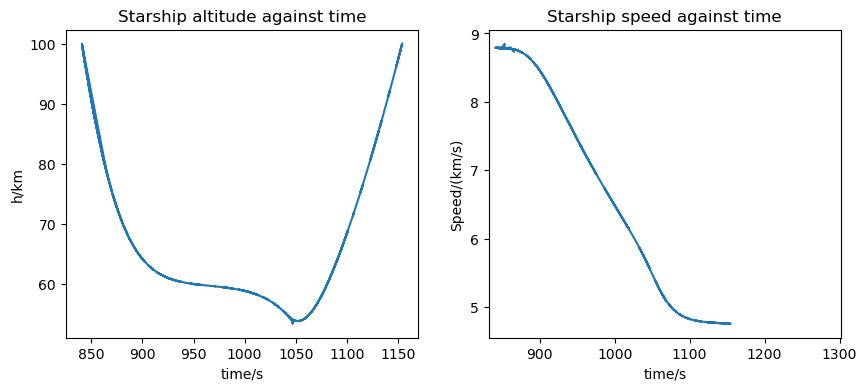

In [1034]:
impact_time = 0
if entry_interface >0:
    print(f"Entry interface at {entry_interface} seconds")
if lithobrake_event.last_t.to(u.s)< prop_time:
    impact_time = lithobrake_event.last_t.to(u.s)
    print(f"Lithobrake event seen at {lithobrake_event.last_t.to(u.s).value} seconds")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))


ax1.set_ylabel("h/km")
# plt.xlabel("distance downrange, km")
ax1.set_title("Starship altitude against time")
ax1.set_xlabel("time/s")
#ax1.set_xlim(left = entry_interface, right=entry_interface+700)
#plt.xlim(12500,14000)
#plt.ylim(top = 100)
#print(reentry_alts)
#plt.ylim(150)
t_in_atm = 460

#ax1.set_xlim(left = entry_interface-10, right=entry_interface+t_in_atm)

ax1.plot(np.array(reentry_time),np.array(reentry_alts))

np_vels = np.array(reentry_vel)
#drag 0.47813373175961593 hours
#none 0.4863379477979069 hours
#print(np.array(reentry_vel)[15])
#plt.ylim(15)
ax2.set_title("Starship speed against time")
ax2.set_xlabel("time/s")
ax2.set_ylabel("Speed/(km/s)")
ax2.set_xlim(left = entry_interface-10, right=entry_interface+t_in_atm)
ax2.plot(np.array(reentry_time),np_vels)

interfaceIndex = np.where(np.array(reentry_time) == entry_interface)
exitIndex = np.where(np.array(reentry_time) == entry_interface+t_in_atm)
#gen_speed_derivative = (np.array(reentry_vel)[interfaceIndex]-np_vels[exitIndex])/(t_in_atm)
print(f"Speed derivative roughly {gen_speed_derivative}")



Max acceleration is 30.39m/s^2 or 3.10g
Max heat flux is 328.43kW/m^2


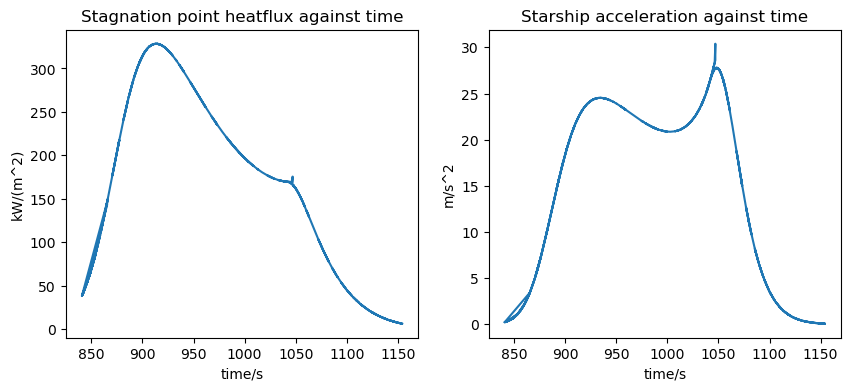

In [1035]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))





ax1.set_ylabel("kW/(m^2)")
# plt.xlabel("distance downrange, km")
ax1.set_xlabel("time/s")
#plt.xlim(12500,14000)
#plt.ylim(top = 100)
#print(reentry_alts)
#plt.ylim(150)
#ax1.set_xlim(2600)
ax1.set_title("Stagnation point heatflux against time")
# ax1.set_ylim(top = 3, bottom = -25)
ax1.plot(np.array(reentry_time),np.array(stagnation_heat_fluxs))
ax2.set_title("Starship acceleration against time")
#ax2.set_ylim(top = 20, bottom = -0)
ax2.set_ylabel("m/s^2")
ax2.set_xlabel("time/s")
ax2.plot(np.array(reentry_time),np.array(reentry_accs_dumb))
max_acc = np.max(np.array(reentry_accs_dumb))
max_flux = np.max(np.array(stagnation_heat_fluxs))

print(f"Max acceleration is {max_acc:.2f}m/s^2 or {max_acc/9.81:.2f}g")
print(f"Max heat flux is {max_flux:.2f}kW/m^2")

# ax2.plot(t_final,a_final*1000, marker='o', linewidth=0.001)
#print(np.array(reentry_time))


In [1036]:
sigma = 5.67*1e-8
temp = 1860
w_e = 0.8*sigma*temp**4/1000
circ_v =7500
print(f"Radiated flux of Starship tile at peak temperature is {w_e}KW/m^2")
print(f"Acceleration to stay in circular orbit at entry interface at {circ_v/1000}km/s is ~{(circ_v**2)/(Mars.R.value+50000):.3f}m/s^2")



Radiated flux of Starship tile at peak temperature is 542.9062267776KW/m^2
Acceleration to stay in circular orbit at entry interface at 7.5km/s is ~16.322m/s^2


In [1037]:
def append_array_as_column(np_array, csv_filename, delimiter=","):
    """
    Appends the given NumPy array as a new column to a CSV file.
    If the file doesn't exist or is empty, it creates it using the array.
    The new array is expected to have the same number of rows as the data in the CSV
    (if the CSV already has data).

    Parameters:
        np_array (array-like): The data to append as a new column.
        csv_filename (str): Path to the CSV file.
        delimiter (str): Delimiter used in the CSV file.
    """
    # Convert input to a NumPy array and ensure it is a column vector.
    data_to_append = np.array(np_array)
    if data_to_append.ndim == 1:
        data_to_append = data_to_append.reshape(-1, 1)
    
    # Check if file exists.
    if not os.path.isfile(csv_filename):
        # File doesn't exist, so write new data.
        np.savetxt(csv_filename, data_to_append, delimiter=delimiter, fmt='%g')
        print(f"File '{csv_filename}' created with new column data.")
        return

    # Check if file is empty (after stripping whitespace)
    with open(csv_filename, "r") as f:
        contents = f.read().strip()
    if not contents:
        # File is empty.
        np.savetxt(csv_filename, data_to_append, delimiter=delimiter, fmt='%g')
        print(f"File '{csv_filename}' was empty; new column data written.")
        return

    # Try to load existing data. If this fails (e.g. file is not in proper numeric format),
    # treat the file as empty.
    try:
        existing_data = np.loadtxt(csv_filename, delimiter=delimiter)
    except Exception as e:
        print(f"Warning: Could not load data from '{csv_filename}'. Treating file as empty. ({e})")
        np.savetxt(csv_filename, data_to_append, delimiter=delimiter, fmt='%g')
        return

    # Ensure existing_data is 2D (even if only one column)
    if existing_data.ndim == 1:
        existing_data = existing_data.reshape(-1, 1)
    
    # Check that the number of rows matches.
    if existing_data.shape[0] != data_to_append.shape[0]:
        raise ValueError("The new data must have the same number of rows as the existing CSV data.")
    
    # Append new column horizontally.
    updated_data = np.hstack((existing_data, data_to_append))
    # Overwrite the CSV file with the updated data.
    np.savetxt(csv_filename, updated_data, delimiter=delimiter, fmt='%g')
    print(f"New column appended to '{csv_filename}'.")

In [1038]:


# # Specify the CSV file path
csv_file1 = "alts_EM.csv"
csv_file2 = "vels_EM.csv"

print(np.array(reentry_vel).size)

# # Append the array to the CSV file
# append_array_as_column(np.array(reentry_accs_dumb[:2299]), csv_file1)
# append_array_as_column(np.array(stagnation_heat_fluxs[:2299]), csv_file2)

2157
